# Object Detection API Demo

<table align="left"><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

Welcome to the [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image.

> **Important**: This tutorial is to help you through the first step towards using [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to build models. If you just just need an off the shelf model that does the job, see the [TFHub object detection example](https://colab.sandbox.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). This notebook includes only what's necessary to run in Colab.

### Install

In [1]:
!pip install -U --pre tensorflow=="2.*"

Requirement already up-to-date: tensorflow==2.* in c:\users\philipp\anaconda3\envs\tensorflow1\lib\site-packages (2.2.0)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2


ERROR: tensorflow-gpu 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.2.2 which is incompatible.
ERROR: tensorflow-gpu 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.2.0 which is incompatible.


Make sure you have `pycocotools` installed

In [ ]:
!pip install pycocotools

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [1]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Compile protobufs and install the object_detection package

In [5]:
%cd models/research/
! protoc object_detection/protos/anchor_generator.proto --python_out=.
! protoc object_detection/protos/argmax_matcher.proto --python_out=.
! protoc object_detection/protos/bipartite_matcher.proto --python_out=.
! protoc object_detection/protos/box_coder.proto --python_out=.
! protoc object_detection/protos/box_predictor.proto --python_out=.
! protoc object_detection/protos/calibration.proto --python_out=.
! protoc object_detection/protos/eval.proto --python_out=.
! protoc object_detection/protos/faster_rcnn.proto --python_out=.
! protoc object_detection/protos/faster_rcnn_box_coder.proto --python_out=.
! protoc object_detection/protos/flexible_grid_anchor_generator.proto --python_out=.
! protoc object_detection/protos/graph_rewriter.proto --python_out=.
! protoc object_detection/protos/grid_anchor_generator.proto --python_out=.
! protoc object_detection/protos/hyperparams.proto --python_out=.
! protoc object_detection/protos/image_resizer.proto --python_out=.
! protoc object_detection/protos/input_reader.proto --python_out=.
! protoc object_detection/protos/keypoint_box_coder.proto --python_out=.
! protoc object_detection/protos/losses.proto --python_out=.
! protoc object_detection/protos/matcher.proto --python_out=.
! protoc object_detection/protos/mean_stddev_box_coder.proto --python_out=.
! protoc object_detection/protos/model.proto --python_out=.
! protoc object_detection/protos/multiscale_anchor_generator.proto --python_out=.
! protoc object_detection/protos/optimizer.proto --python_out=.
! protoc object_detection/protos/pipeline.proto --python_out=.
! protoc object_detection/protos/post_processing.proto --python_out=.
! protoc object_detection/protos/preprocessor.proto --python_out=.
! protoc object_detection/protos/region_similarity_calculator.proto --python_out=.
! protoc object_detection/protos/square_box_coder.proto --python_out=.
! protoc object_detection/protos/ssd.proto --python_out=.
! protoc object_detection/protos/ssd_anchor_generator.proto --python_out=.
! protoc object_detection/protos/string_int_label_map.proto --python_out=.
! protoc object_detection/protos/target_assigner.proto --python_out=.
! protoc object_detection/protos/train.proto --python_out=.

c:\tensorflow1\models\research


object_detection/protos/*.proto: No such file or directory


In [3]:
%%bash 
cd models/research
pip install .

Couldn't find program: 'bash'


### Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
tf.compat.v1.enable_eager_execution()

Patches:

In [3]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loader

In [4]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

#   model = tf.saved_model.load(str(model_dir))
  model = tf.saved_model.load_v2(str(model_dir))
  model = model.signatures['serving_default']

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [5]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'c:/tensorflow1/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [6]:
import pathlib
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('c:/tensorflow1/models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('c:/tensorflow1/models/research/object_detection/test_images/image1.jpg'),
 WindowsPath('c:/tensorflow1/models/research/object_detection/test_images/image2.jpg')]

# Detection

Load an object detection model:

In [7]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8: 

In [8]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(?, ?, ?, 3) dtype=uint8>]


And returns several outputs:

In [9]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [10]:
detection_model.output_shapes

{'detection_boxes': TensorShape([Dimension(None), Dimension(100), Dimension(4)]),
 'detection_classes': TensorShape([Dimension(None), Dimension(100)]),
 'detection_scores': TensorShape([Dimension(None), Dimension(100)]),
 'num_detections': TensorShape([Dimension(None)])}

Add a wrapper function to call the model, and cleanup the outputs:

In [11]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [12]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

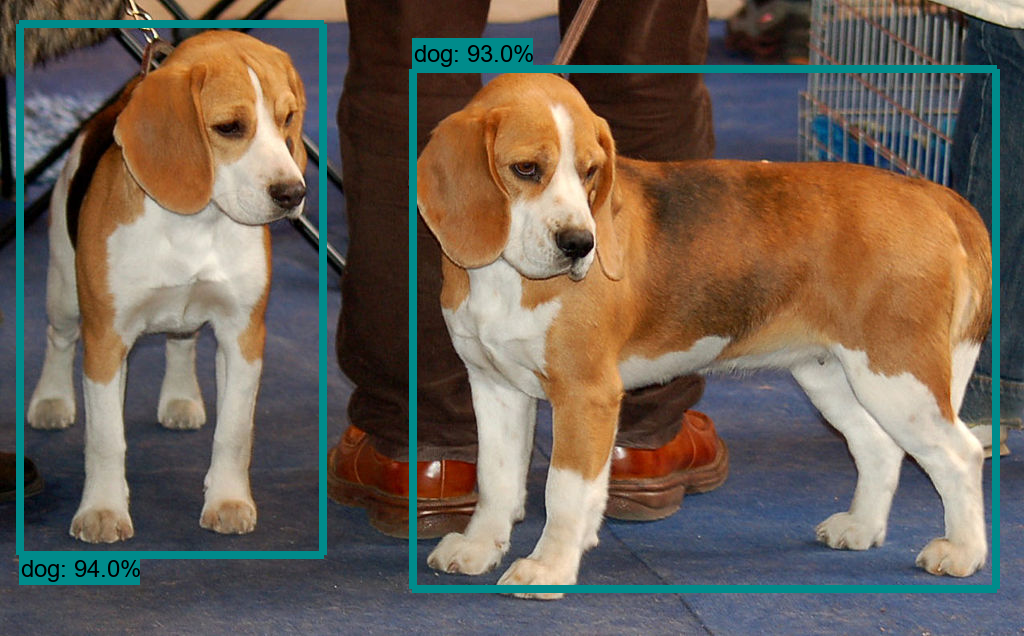

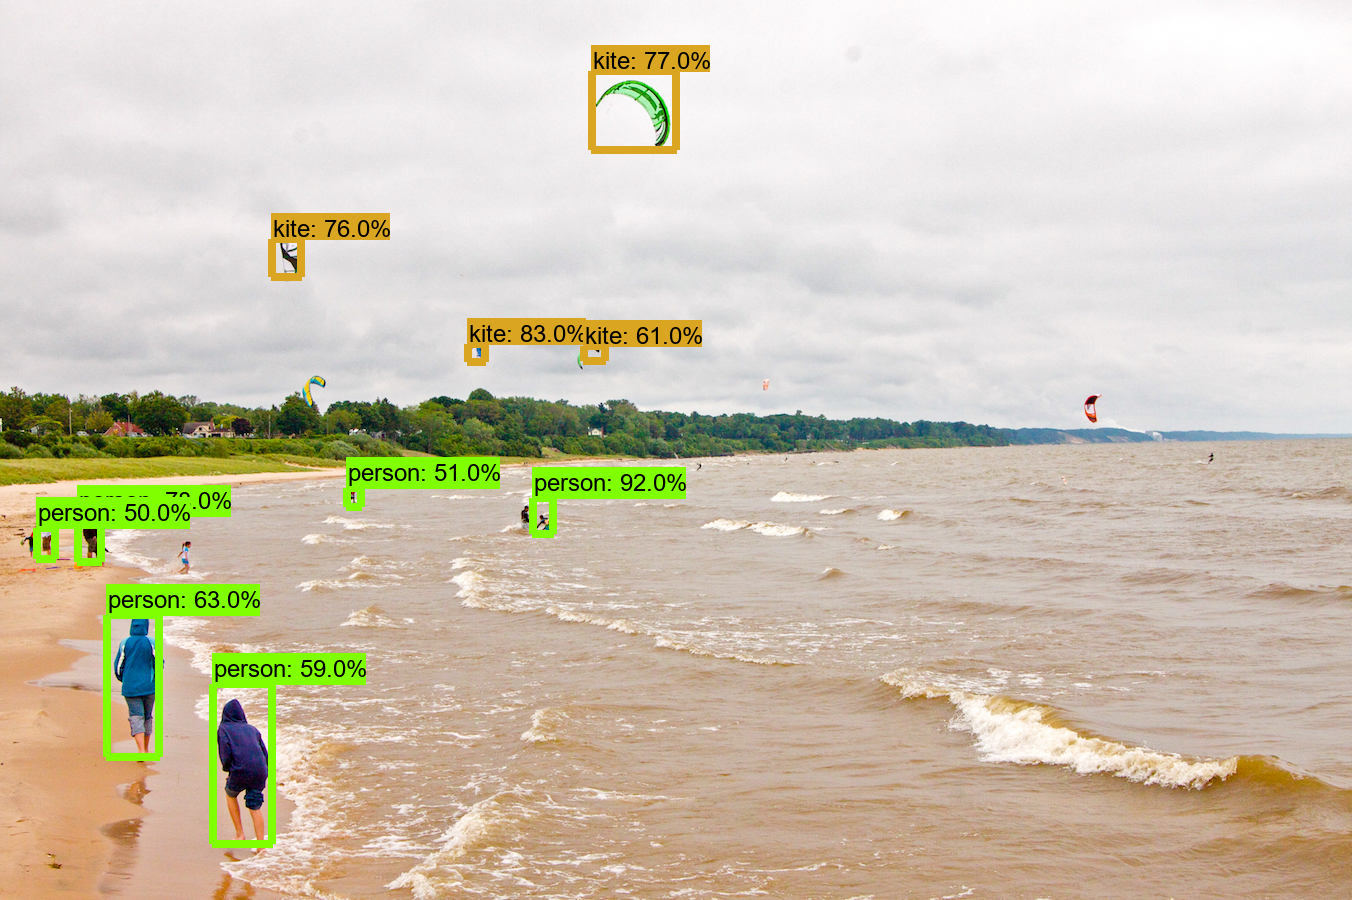

In [13]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)


## Instance Segmentation

In [14]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model(model_name)

727392256/727390102 [==============================] - 603s 1us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


The instance segmentation model includes a `detection_masks` output:

In [15]:
masking_model.output_shapes

{'detection_boxes': TensorShape([Dimension(None), Dimension(100), Dimension(4)]),
 'detection_classes': TensorShape([Dimension(None), Dimension(100)]),
 'detection_masks': TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(None)]),
 'detection_scores': TensorShape([Dimension(None), Dimension(100)]),
 'num_detections': TensorShape([Dimension(None)])}

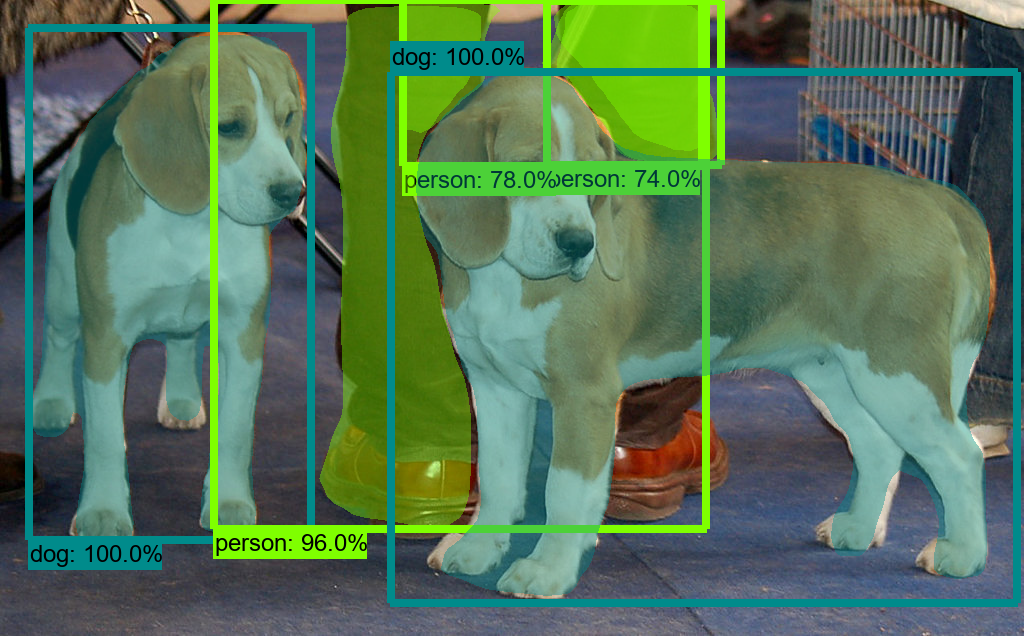

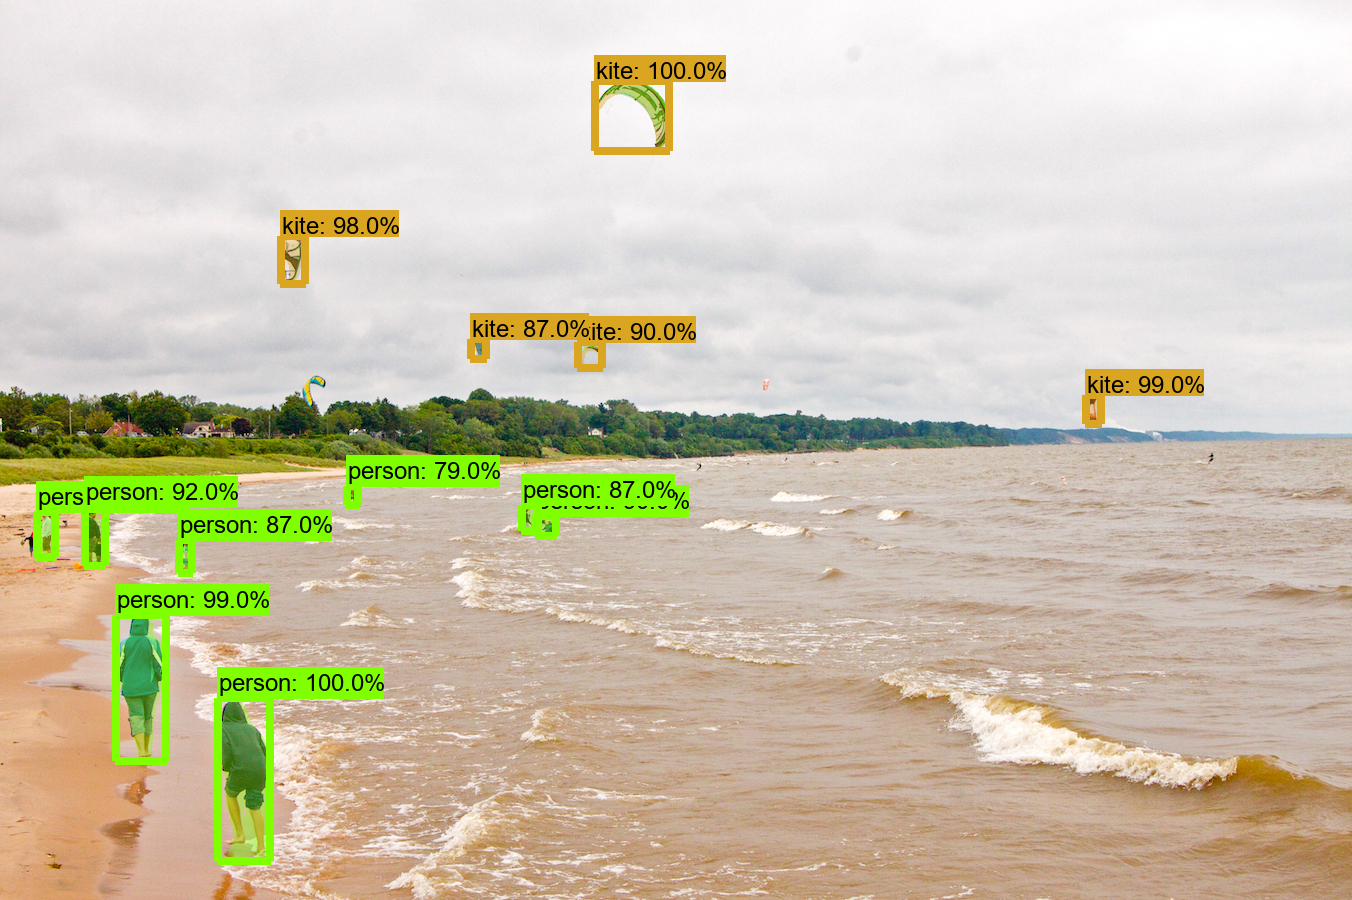

In [16]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)